In [2]:
import tensorflow as tf
import urllib
!pip install python_speech_features
from python_speech_features import mfcc, delta, logfbank
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from random import shuffle
import numpy as np

from os import listdir, getcwd
from os.path import join, isfile, isdir
from pprint import pprint

from utils import hello_world
hello_world()

  Stored in directory: /home/capcolabs/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features
You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Hello World!


# RNN for Classification

For our classification problem we will use a relatively simple dataset that can be understood, the `Google Speech Data` which includes short snippets of audio data that involve certain trigger words.

While not directly applicable to Financial Services, the process of feature choice and extraction are well demonstrated by the use case choice.

In [3]:
base_data_path = "/data/speech/"

print(listdir(base_data_path))

FileNotFoundError: [Errno 2] No such file or directory: '/data/speech/'

In [119]:
base_data_path = "/data/speech/"
commands = [
    "one",
    "two",
    "three",
    "four",
    "five",
    "six",
    "seven",
    "eight",
    "nine",
    "zero"
]
dirs = [
    join(base_data_path, d) for d in listdir(base_data_path)
    if isdir(join(base_data_path, d)) and
    d in commands
]
numbers = {
    d: [ 
        join(base_data_path, d, f) for f in listdir(join(base_data_path,d))
        if f[-3:] == "wav"
    ] for d in listdir(base_data_path)
    if isdir(join(base_data_path, d)) and
    d in commands
}
pprint(dirs)

MAPPING = {
    "one": 1,
    "two": 2,
    "three": 3,
    "four": 4,
    "five": 5,
    "six": 6,
    "seven": 7,
    "eight": 8,
    "nine": 9,
    "zero": 0
}

['/data/speech/eight',
 '/data/speech/nine',
 '/data/speech/three',
 '/data/speech/one',
 '/data/speech/zero',
 '/data/speech/seven',
 '/data/speech/two',
 '/data/speech/six',
 '/data/speech/five',
 '/data/speech/four']


In [121]:
eights = numbers['eight']
print(eights[0])

/data/speech/eight/bb05582b_nohash_3.wav


In [125]:
from pydub import AudioSegment
from pydub.playback import play

audio = AudioSegment.from_wav(eights[0])
play(audio)

# Feature Extraction

Raw signal isn't always the best choice for solving a ML problem.  In this case one of the commonly accepted feature choices for audio processing is Mel-frequency cepstral coefficients or MFCC.

From: https://en.wikipedia.org/wiki/Mel-frequency_cepstrum#:~:text=Mel%2Dfrequency%20cepstral%20coefficients%20(MFCCs,%2Da%2Dspectrum%22).

>Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC[1]. They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). The difference between the cepstrum and the mel-frequency cepstrum is that in the MFC, the frequency bands are equally spaced on the mel scale, which approximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal cepstrum. This frequency warping can allow for better representation of sound, for example, in audio compression.

>MFCCs are commonly derived as follows:[2]

- Take the Fourier transform of (a windowed excerpt of) a signal.
- Map the powers of the spectrum obtained above onto the mel scale, using triangular overlapping windows.
- Take the logs of the powers at each of the mel frequencies.
- Take the discrete cosine transform of the list of mel log powers, as if it were a signal.
- The MFCCs are the amplitudes of the resulting spectrum.
- There can be variations on this process, for example: differences in the shape or spacing of the windows used to map the scale,[3] or addition of dynamics features such as "delta" and "delta-delta" (first- and second-order frame-to-frame difference) coefficients.[4]

Since we're using Python, there's a library for that, `python_speech_features`, which will simplify our work.

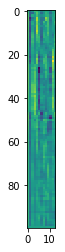

In [126]:
from python_speech_features import mfcc, delta, logfbank

def calculate_mfcc(filename: str, pad=100):
    """
    
    """
    (rate,sig) = wav.read(filename)
    mfcc_feat = mfcc(sig,rate)
    steps, feats = mfcc_feat.shape
    if steps < pad:
        mfcc_feat = np.vstack([mfcc_feat, np.zeros((pad-steps, 13))])
    else:
        mfcc_feat = mfcc_feat[:pad]
    return mfcc_feat
    
fig = plt.imshow(calculate_mfcc(eights[0]))

# Data Set Creation

Once we have our initial feature choice, we now need to create our dataset.  We will write a function which will output the dataset as a `dict`, with keys keeping track of each of the components:
- `X_train`
- `y_train`
- `X_test`
- `y_test`
- `X_val`
- `y_val`

In [130]:
def create_dataset(validation_split=0.1, test_split=0.1):
    """
    
    """
    X_train = []
    y_train = []
    X_val   = []
    y_val   = []
    X_test  = []
    y_test  = []
    
    for num in numbers:
        shuffle(numbers[num])
        total = len(numbers[num])
        num_test = int(test_split * total)
        num_val  = int(validation_split * total)
        num_train = total - num_test - num_val
        n_train, n_val, n_test = numbers[num][:num_train], \
            numbers[num][num_train:num_train+num_val], \
            numbers[num][num_train+num_val:]
        X_train.extend(n_train)
        y_train.extend([MAPPING[num] for _ in n_train])
        X_val.extend(n_val)
        y_val.extend([MAPPING[num] for _ in n_val])
        X_test.extend(n_test)
        y_test.extend([MAPPING[num] for _ in n_test])
        
    print(f"""
    Creating Training Set
    """)

    Audio_train = []
    for idx, x in enumerate(X_train):
        Audio_train.append(calculate_mfcc(x))
        if idx % 100 == 0:
            print(".", end="")
            if idx % 5000 == 0:
                print("")
    
    print(f"""
    Creating Validation Set
    """)
    Audio_val = []
    for idx, x in enumerate(X_val):
        Audio_val.append(calculate_mfcc(x))
        if idx % 100 == 0:
            print(".", end="")
            if idx % 5000 == 0:
                print("")
    
    print(f"""
    Creating Testing Set
    """)
    Audio_test = []
    for idx, x in enumerate(X_test):
        Audio_test.append(calculate_mfcc(x))
        if idx % 100 == 0:
            print(".", end="")
            if idx % 5000 == 0:
                print("")
        
    return {
        "X_train": np.array(Audio_train),
        "y_train": y_train,
        "X_val": np.array(Audio_val),
        "y_val": y_val,
        "X_test": np.array(Audio_test),
        "y_test": y_test
    }

Data = create_dataset()


    Creating Training Set
    
.
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
...........
    Creating Validation Set
    
.
......................................
    Creating Testing Set
    
.
......................................

In [131]:
# print(Data['X_train'].reshape(31134, 83, 13))
S = Data['X_train'].shape
print(S)
Shapes = set()
for x in Data['X_train']:
    if x.shape != S:
        Shapes.add(x.shape)
        
print(Shapes)

(31134, 100, 13)
{(100, 13)}


In [132]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (Data["X_train"], Data["y_train"]))

test_dataset = tf.data.Dataset.from_tensor_slices((Data["X_val"], Data["y_val"]))

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [133]:
from tensorflow.keras import Sequential

def create_model(*args, **kwargs):
    """
    
    """
    model = Sequential([
        tf.keras.Input(shape=(100,13)),
        tf.keras.layers.LSTM(512, return_sequences=True),
        tf.keras.layers.LSTM(512),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ]
    )
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy']
    )
    
    model.summary()
    
    return model
    
model = create_model()

W1106 19:00:35.482863 4386952640 deprecation.py:506] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer_utils.py:127: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 100, 512)          1077248   
_________________________________________________________________
lstm_22 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dense_21 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_22 (Dense)             (None, 10)                1290      
Total params: 3,243,402
Trainable params: 3,243,402
Non-trainable params: 0
_________________________________________________________________


In [134]:
model.fit(
    train_dataset, 
    validation_data=test_dataset,
    epochs=1
)

 35/487 [=>............................] - ETA: 20:42 - loss: 1035.9438 - acc: 0.0049

KeyboardInterrupt: 

# Comparison of Results

Since we have classification problem with relatively few (and balanced!) classes, accuracy is a good metric for how well a network is performing, on top of that, a confusion matrix is also a useful metric for the performance.

In [135]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           #xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


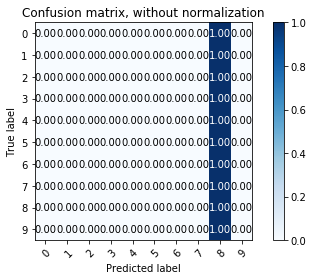

In [136]:
y_pred = model.predict_classes(Data['X_test'])
y_test = Data['y_test']
class_names=[0,1,2,3,4,5,6,7,8,9]

plot = plot_confusion_matrix(
    y_test, y_pred, classes=class_names,
    normalize=True,
    title='Confusion matrix, without normalization'
)
plt.show(plot)

Clearly this initial example performs poorly (in completely trained)

# RNN for Regression

Initial Example Taken From: https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

Other Resources: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


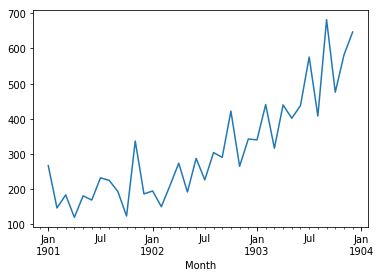

In [137]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
# load dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
series = read_csv(
    'sample.csv', 
    header=0, 
    parse_dates=[0], 
    index_col=0, 
    squeeze=True, 
    date_parser=parser
)
# summarize first few rows
print(series.head())
# line plot
series.plot()
pyplot.show()

In [139]:
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
# load dataset

def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

series = read_csv(
    'sample.csv', 
    header=0, 
    parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# split data into train and test
X = series.values

print(X)

[266.  145.9 183.1 119.3 180.3 168.5 231.8 224.5 192.8 122.9 336.5 185.9
 194.3 149.5 210.1 273.3 191.4 287.  226.  303.6 289.9 421.6 264.5 342.3
 339.7 440.4 315.9 439.3 401.3 437.4 575.5 407.6 682.  475.3 581.3 646.9]


RMSE: 136.761


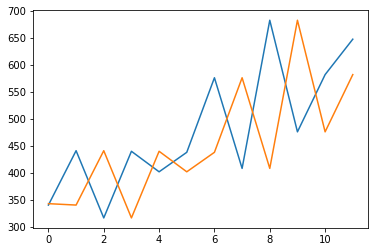

In [140]:
train, test = X[0:-12], X[-12:]

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# make prediction
	predictions.append(history[-1])
	# observation
	history.append(test[i])
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(test)
pyplot.plot(predictions)
pyplot.show()

In [9]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

series = read_csv('sample.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# transform to supervised learning
X = series.values
supervised = timeseries_to_supervised(X, 1)
print(supervised.head())

       0      0
0    0.0  266.0
1  266.0  145.9
2  145.9  183.1
3  183.1  119.3
4  119.3  180.3


Month=1, Predicted=302.429698, Expected=339.700000
Month=2, Predicted=380.287788, Expected=440.400000
Month=3, Predicted=329.509700, Expected=315.900000
Month=4, Predicted=417.837868, Expected=439.300000
Month=5, Predicted=317.003226, Expected=401.300000
Month=6, Predicted=440.112508, Expected=437.400000
Month=7, Predicted=455.792155, Expected=575.500000
Month=8, Predicted=367.190809, Expected=407.600000
Month=9, Predicted=433.156745, Expected=682.000000
Month=10, Predicted=239.342620, Expected=475.300000
Month=11, Predicted=236.821339, Expected=581.300000
Month=12, Predicted=308.922667, Expected=646.900000
Test RMSE: 177.768


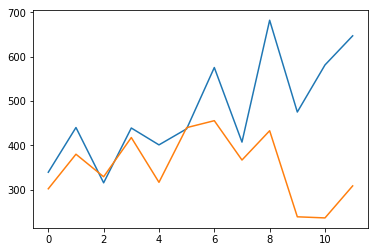

In [141]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# load dataset
series = read_csv('sample.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(
    mean_squared_error(raw_values[-12:], predictions)
)

print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()

# Multivariate Regression

Our next example will deal with `Multivariate Time-Series Forcasting`, using an example taken from: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

The goal of this model is:

>Given the weather conditions and pollution for prior hours, can we forecast the pollution at the next hour. 

We first bring in our main imports for the data engineering and model creation:

In [142]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

We then need to modify the original `csv` and put it into a format that we can use for our `RNN`.  We also fill in any `NAN` values with `0`.

In [143]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


So we can get an idea of how the data is related, we will plot out the various column values.

> Keep in mind that we want to predict the `pollution` value.

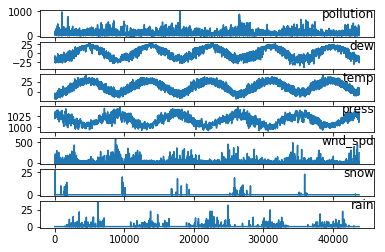

In [144]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

We now need to convert the data into a format that we can use for prediction.

In [145]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


# Split Data and Train Model

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)
Train on 8760 samples, validate on 35039 samples
Epoch 1/50
8760/8760 - 14s - loss: 0.0616 - val_loss: 0.0555
Epoch 2/50
8760/8760 - 1s - loss: 0.0459 - val_loss: 0.0608
Epoch 3/50
8760/8760 - 1s - loss: 0.0274 - val_loss: 0.0574
Epoch 4/50
8760/8760 - 1s - loss: 0.0177 - val_loss: 0.0497
Epoch 5/50
8760/8760 - 1s - loss: 0.0163 - val_loss: 0.0373
Epoch 6/50
8760/8760 - 1s - loss: 0.0154 - val_loss: 0.0262
Epoch 7/50
8760/8760 - 1s - loss: 0.0151 - val_loss: 0.0229
Epoch 8/50
8760/8760 - 1s - loss: 0.0149 - val_loss: 0.0212
Epoch 9/50
8760/8760 - 1s - loss: 0.0149 - val_loss: 0.0191
Epoch 10/50
8760/8760 - 1s - loss: 0.0147 - val_loss: 0.0176
Epoch 11/50
8760/8760 - 1s - loss: 0.0148 - val_loss: 0.0170
Epoch 12/50
8760/8760 - 1s - loss: 0.0148 - val_loss: 0.0157
Epoch 13/50
8760/8760 - 1s - loss: 0.0146 - val_loss: 0.0150
Epoch 14/50
8760/8760 - 1s - loss: 0.0146 - val_loss: 0.0144
Epoch 15/50
8760/8760 - 1s - loss: 0.0145 - val_loss: 0.0143


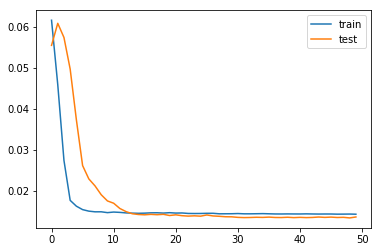

In [149]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

model.compile(
    loss='mae', 
    optimizer='adam'
)
# fit network
history = model.fit(
    train_X, 
    train_y, 
    epochs=50, 
    batch_size=72, 
    validation_data=(test_X, test_y), 
    verbose=2, 
    shuffle=False
)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [150]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.577


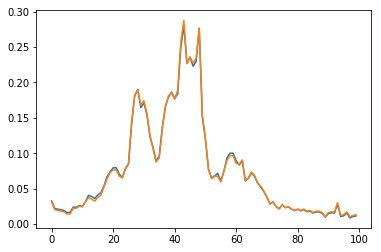

In [155]:
cutoff = 100
plt.plot(yhat[1:cutoff+1])
plt.plot(test_y[:cutoff])

In [ ]:
Test RMSE: 26.544

# Applications to Finance

In the previous example we see that each column has an influence on the predictions for the `pollution` value that we are trying to predict for the next hour.  To expand this concept to finance we can use data we have taken from `Yahoo Finance` as our base time series and decide what we want to predict.

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


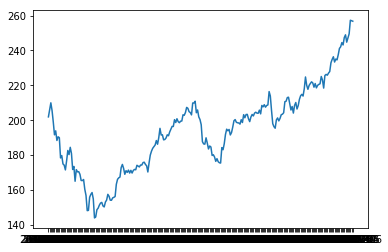

In [109]:
def parse_yahoo(x):
	return datetime.strptime(x, '%Y-%m-%d')

dataset = read_csv(
    'AAPL.csv'
)

print(dataset.columns)

plt.plot(
    dataset['Date'],
    dataset['Open']
)

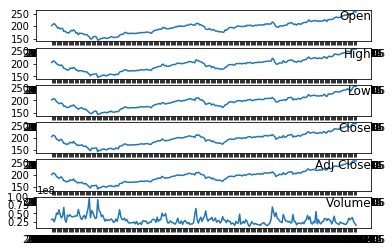

In [66]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset

# specify columns to plot
groups = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
i = 1
# plot each column
pyplot.figure()
for idx, group in enumerate(groups):
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(dataset['Date'], dataset[group])
	pyplot.title(dataset.columns[idx+1], y=0.5, loc='right')
	i += 1
pyplot.show()